In [113]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
from os import listdir
from os.path import isfile, join
from sklearn.linear_model import LinearRegression
plt.rcParams["figure.figsize"] = (20,10)

In [90]:
log_dir = "stress_logs"

In [91]:
stress_files = [f for f in listdir(log_dir) if isfile(join(log_dir, f))]
stress_files[:5]

['stressPut5800Entries.KeyLen20.log',
 'stressPut4600Entries.KeyLen20.log',
 'stressPut2800Entries.KeyLen20.log',
 'stressPut8800Entries.KeyLen20.log',
 'stressPutAndDel7.KeyLen20.log']

## Кейс: PutWithSameKeyNumberNtimes
Проанализируем данные, где в леджер идет запись одинакового множества ключей несколько раз. Сравниваться будут однократный вызов PutStateBatch и вызов PutState/PutPrivateData в цикле, так как последние методы могут записывать по одному ключу за раз.

In [92]:
stress_put_files = [f for f in stress_files if f.startswith("stressPut") and 'Del' not in f]
stress_put_files[:5]

['stressPut5800Entries.KeyLen20.log',
 'stressPut4600Entries.KeyLen20.log',
 'stressPut2800Entries.KeyLen20.log',
 'stressPut8800Entries.KeyLen20.log',
 'stressPut7600Entries.KeyLen20.log']

In [93]:
# Function to read test files
def readFiles(log_files, stress_tests):
    for f in log_files:
        with open(join(log_dir, f), 'r') as reader:
            lines = reader.readlines()
            for line in lines:
                obj = json.loads(line)
                stress_tests.append(obj)
            

In [94]:
put_stress_tests = []

readFiles(stress_put_files, put_stress_tests)

In [95]:
putTestDf = pd.DataFrame.from_records(put_stress_tests)

In [96]:
putTestDf.head()

,method,entries,millis,keylen,batchapi,collection,seed
0,put,5800,6,20,True,,10
1,put,5800,7,20,True,,10
2,put,5800,13,20,True,,10
3,put,5800,7,20,True,,10
4,put,5800,7,20,True,,10


In [97]:
# In case if log files contain not only "put" method
putTestDf = putTestDf.loc[putTestDf['method'] == 'put']

In [98]:
# Get entries with BatchAPI
putTestDfBatch = putTestDf.loc[putTestDf['batchapi'] == True]
putTestDfBatch.head()

,method,entries,millis,keylen,batchapi,collection,seed
0,put,5800,6,20,True,,10
1,put,5800,7,20,True,,10
2,put,5800,13,20,True,,10
3,put,5800,7,20,True,,10
4,put,5800,7,20,True,,10


In [99]:
# Get entries without use of BatchAPI
putTestDfNoBatch = putTestDf.loc[putTestDf['batchapi'] == False]
putTestDfNoBatch.head()

,method,entries,millis,keylen,batchapi,collection,seed
10,put,5800,2153,20,False,,10
11,put,5800,2026,20,False,,10
12,put,5800,1952,20,False,,10
13,put,5800,2211,20,False,,10
14,put,5800,2149,20,False,,10


In [100]:
putTestBatchMean = putTestDfBatch.groupby(['entries']).mean()
putTestBatchMean.head()

,millis,keylen,batchapi,seed
entries,,,,
100,0.65,20.0,True,10.0
400,1.15,20.0,True,10.0
700,1.35,20.0,True,10.0
1000,1.70,20.0,True,10.0
1300,1.70,20.0,True,10.0


In [101]:
putTestNoBatchMean = putTestDfNoBatch.groupby(['entries']).mean()
putTestNoBatchMean.head()

,millis,keylen,batchapi,seed
entries,,,,
100,41.20,20.0,False,10.0
400,156.35,20.0,False,10.0
700,268.60,20.0,False,10.0
1000,389.60,20.0,False,10.0
1300,502.65,20.0,False,10.0


In [142]:
# Function to calculate linear regression
def linear_regression(df):
    y = np.array(df['millis'])
    x = np.array(df['entries']).reshape((-1, 1))
    model = LinearRegression()
    model.fit(x, y)
    r_sq = model.score(x, y)
    return [r_sq, model.intercept_, model.coef_[0]]

In [151]:
# Function to plot error bars
def plot_error_bars(groupdf, title, coef, interc, r2):
    mean = np.array(groupdf.mean()['millis'])
    std = np.array(groupdf.std()['millis'])
    entries = [name for name, _ in groupdf]
    linfunc = lambda x: coef * x + interc
    x = np.array([100, 10000])
    plt.title(title)
    plt.xlabel("Number of keys")
    plt.ylabel("Milliseconds")
    plt.errorbar(entries, mean, std, fmt='--o')
    plt.plot(x, linfunc(x), label="{:.6f} * x + {:.6f}, R^2 = {:.4}".format(coef, interc, r2))
    plt.legend()
    plt.show()
    

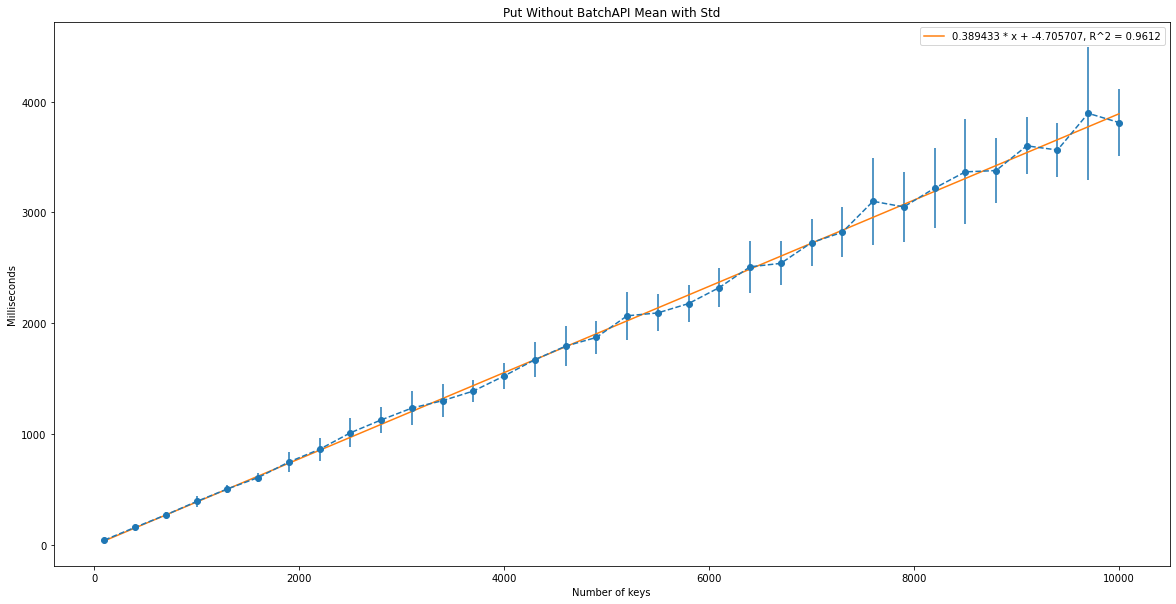

In [154]:
[r2, interc, coef] = linear_regression(putTestDfNoBatch)

plot_error_bars(putTestDfNoBatch.groupby('entries'), "Put Without BatchAPI Mean with Std", coef, interc, r2)

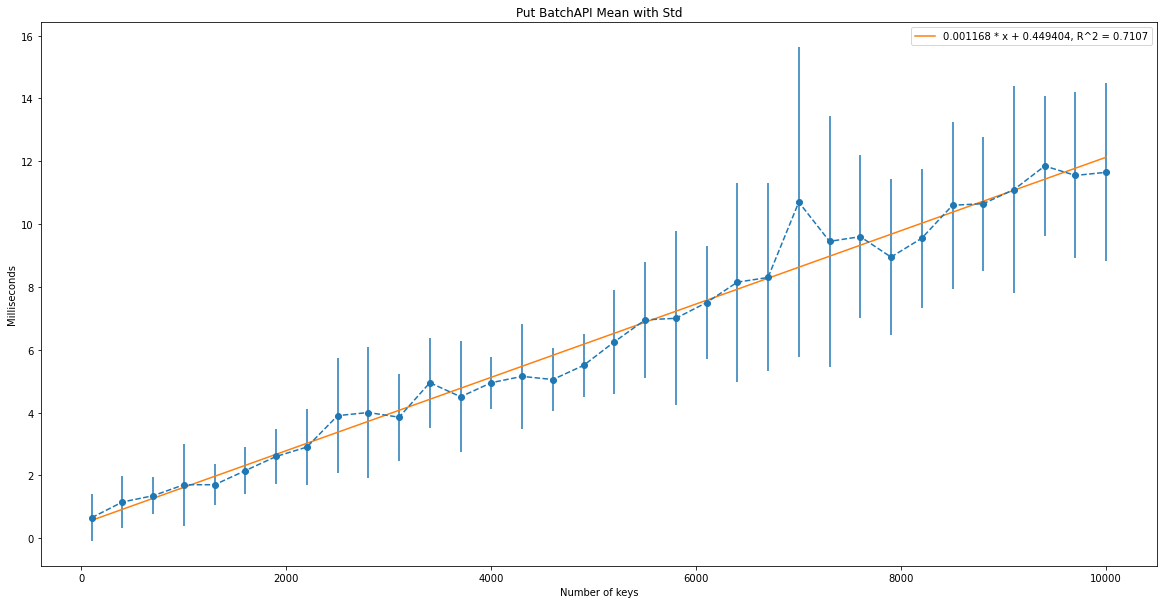

In [155]:
[r2, interc, coef] = linear_regression(putTestDfBatch)
plot_error_bars(putTestDfBatch.groupby('entries'), "Put BatchAPI Mean with Std", coef, interc, r2)

## Кейс: DelState vs DelStateBatch
Проанализируем данные, где происходит удаление данных из леджера

In [160]:
del_files = [f for f in stress_files if "PutAndDel" in f]
del_files[:5]

['stressPutAndDel7.KeyLen20.log',
 'stressPutAndDel6.KeyLen20.log',
 'stressPutAndDel1.KeyLen20.log',
 'stressPutAndDel8.KeyLen20.log',
 'stressPutAndDel9.KeyLen20.log']

In [161]:
del_tests = []

readFiles(del_files, del_tests)

delTestDf = pd.DataFrame.from_records(del_tests)
delTestDf.head()

,method,entries,millis,keylen,batchapi,collection,seed
0,put,100,0,20,True,,10
1,del,100,1,20,True,,10
2,put,400,2,20,True,,10
3,del,400,0,20,True,,10
4,put,700,1,20,True,,10


In [162]:
# We need only "method=del" data
delTestDf = delTestDf.loc[delTestDf["method"] == "del"]
delTestDf.head()

,method,entries,millis,keylen,batchapi,collection,seed
1,del,100,1,20,True,,10
3,del,400,0,20,True,,10
5,del,700,1,20,True,,10
7,del,1000,1,20,True,,10
9,del,1300,2,20,True,,10


In [163]:
# Get entries with BatchAPI
delTestDfBatch = delTestDf.loc[delTestDf['batchapi'] == True]
delTestDfBatch.head()

,method,entries,millis,keylen,batchapi,collection,seed
1,del,100,1,20,True,,10
3,del,400,0,20,True,,10
5,del,700,1,20,True,,10
7,del,1000,1,20,True,,10
9,del,1300,2,20,True,,10


In [164]:
# Get entries without use of BatchAPI
delTestDfNoBatch = delTestDf.loc[delTestDf['batchapi'] == False]
delTestDfNoBatch.head()

,method,entries,millis,keylen,batchapi,collection,seed
273,del,100,50,20,False,,10
275,del,400,151,20,False,,10
277,del,700,253,20,False,,10
279,del,1000,377,20,False,,10
281,del,1300,483,20,False,,10


In [166]:
# BatchAPI Del invokations mean by entries
delTestBatchMean = delTestDfBatch.groupby(['entries']).mean()
delTestBatchMean.head()

,millis,keylen,batchapi,seed
entries,,,,
100,0.666667,20.0,True,10.0
400,0.750000,20.0,True,10.0
700,1.416667,20.0,True,10.0
1000,2.250000,20.0,True,10.0
1300,2.083333,20.0,True,10.0


In [167]:
# Without use of BatchAPI Del invokations mean by entries
delTestNoBatchMean = delTestDfNoBatch.groupby(['entries']).mean()
delTestNoBatchMean.head()

,millis,keylen,batchapi,seed
entries,,,,
100,44.00,20.0,False,10.0
400,157.00,20.0,False,10.0
700,265.50,20.0,False,10.0
1000,399.00,20.0,False,10.0
1300,490.25,20.0,False,10.0


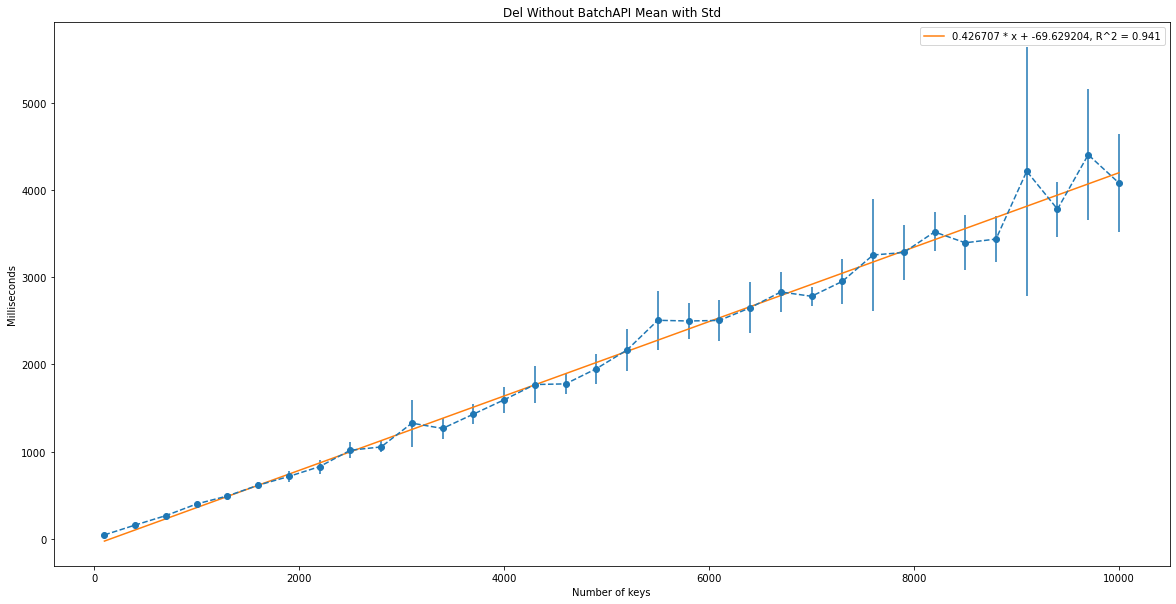

In [169]:
[r2, interc, coef] = linear_regression(delTestDfNoBatch)

plot_error_bars(delTestDfNoBatch.groupby('entries'), "Del Without BatchAPI Mean with Std", coef, interc, r2)

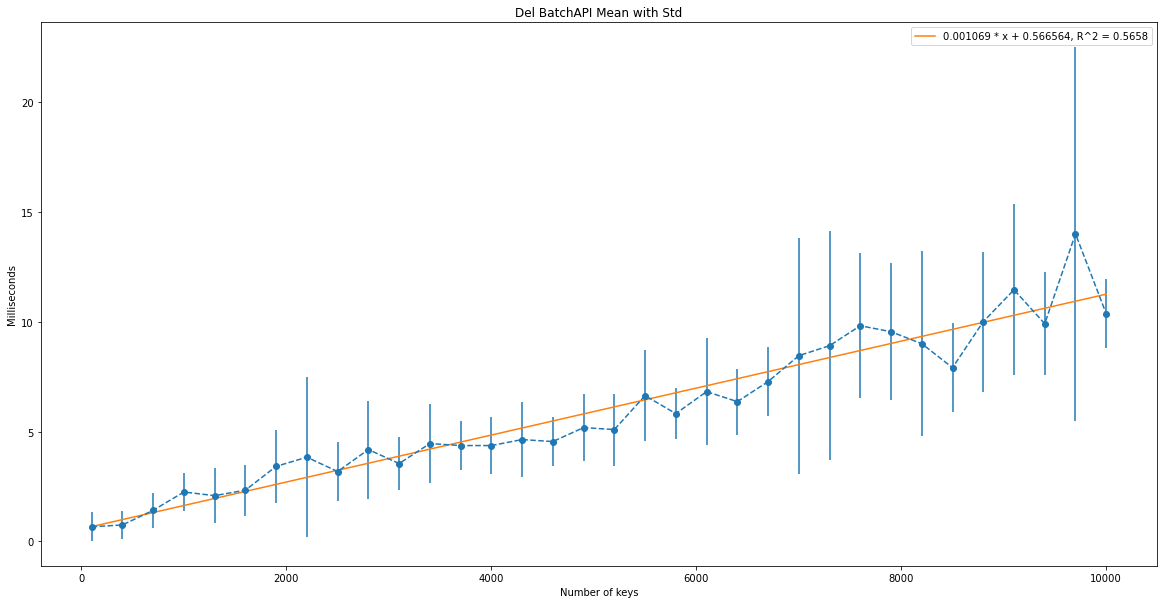

In [170]:
[r2, interc, coef] = linear_regression(delTestDfBatch)
plot_error_bars(delTestDfBatch.groupby('entries'), "Del BatchAPI Mean with Std", coef, interc, r2)

## Кейс: GetRange vs GetStateBatch
Проанализируем данные, где происходит чтение данных GetStateByRange и GetStateBatch

In [157]:
getrange_files = [f for f in stress_files if "GetRangeVSBatchAPI" in f]
getrange_files[:5]

['scenarioGetRangeVSBatchAPI1.log']

In [159]:
getrange_tests = []

readFiles(getrange_files, getrange_tests)

putTestDf = pd.DataFrame.from_records(getrange_tests)
putTestDf.head()

,method,entries,millis,batchapi
0,getrange,3337,64,False
1,getrange,4001,30,True
2,getrange,3337,52,False
3,getrange,4001,26,True
4,getrange,3337,48,False
